<a href="https://colab.research.google.com/github/larissa-eleterio/portfolio-larissa-eleterio/blob/master/Detec%C3%A7%C3%A3o_de_fraudes_em_cart%C3%A3o_de_cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Fraudes em Cartões de Crédito

As técnicas de machine learning são excelentes aliados nas estratégias de detecção de fraudes principalmente para o e-commerce. Evitar fraudes é um importante desafio para instituições financeiras como bancos e *fintechs*.
Nesse projeto vamos aplicar machine learning para detectar fraudes em cartões de crédito.

Segundo reportagem da revista [*Isto é*](https://www.istoedinheiro.com.br/e-commerce-como-prevenir-fraudes-com-inteligencia-artificial/),
a partir do levantamento feito pela Juniper Research, as transações fraudulentas em varejo aumentaram em 2019 e  há uma previsão de que dobrem para US$ 25 bilhões até o final de 2020. Ainda, segundo o relatório, durante a pandemia, houve um aumento de 18% nas tentativas de fraude.

Nesse projeto vamos propor uma estratégia utilizando regressão logística para detecção de fraudes em cartões de crédito.

<p align=center>
<img src="https://www.creditcards.com/credit-card-news/wp-content/uploads/how-to-report-and-protect-yourself-from-credit-card-fraud-and-identity-theft.jpg" width="60%"></p>



## Importando os Dados

Os dados aqui analisados estão disponíveis no [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud), e contêm transações realizadas com cartões de crédito europeus em setembro de 2013 ao longo de dois dias.

Os dados são não identificáveis de forma que estão disponíveis apenas variáveis ​​de entrada numéricas que são o resultado de uma transformação PCA (Análise de componentes principais).

Se você não está familiarizado com essa técnica, você pode acessar o meu notebook [*Aplicando análise de componetes principais na criação de um KPI*](https://bit.ly/2B8wqVj) onde criei um indicador utilizando essa mesma técnica de análise multivariada e expliquei mais detalhes sobre ela.

As variáveis V1, V2,… V28 são as componentes principais obtidos com o PCA, os únicos recursos que não foram transformados com o PCA são 'Time' e 'Amount'. O recurso 'Hora' contém os segundos decorridos entre cada transação e a primeira transação no conjunto de dados. Além disso o dataset disponibiliza a coluna 'Classe' que é a variável de resposta e assume o valor 1 em caso de fraude e 0 em caso contrário.


<p align=center>
<img src="https://www.paymentsjournal.com/wp-content/uploads/2019/02/hack-3671982_1920-1-750x375.jpg" width="50%"></p>



In [ ]:
!pip install scikit-plot

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

In [3]:
#Fazendo a leitura dos dados
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

df = pd.read_csv(file_path)

## Análise exploratória dos dados

Primeiro, é preciso explorar os dados para entender se existem outliers ou valores ausentes, além de analisar a distribuição das variáveis para identificar se há algum desbalanceamento dos dados.

In [4]:
#Ajustando o formato do dataset
pd.options.display.float_format = "{:.2f}".format

# Medidas resumo dos dados
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.77,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,12.02,7.85,7.13,10.53,8.88,17.32,9.25,5.04,5.59,39.42,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


Aparentemente nenhuma variável apresenta valores aberrantes (discrepantes) de forma a nos conduzir ao tratamento de outliers. Seguimos então pra verificação de valores ausentes.

In [5]:
# Detectando valores ausentes
df.isnull().sum().max()

0

Utilizando-se das medidas resumo apresentadas, não há indícios então de que seja necessário um tratamento de valores ausentes ou outliers.

### Análise Gráfica

Nosso próximo passo é verificar o balanceamento dos dados, essa etapa é essencial para a etapa de divisão dos dados de treino e teste.

Isso porque, dados desbalanceados podem gerar um modelo viesado e desejamos evitar isso.

In [6]:
#Código para mostrar nossas porcentagens no gráfico
def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

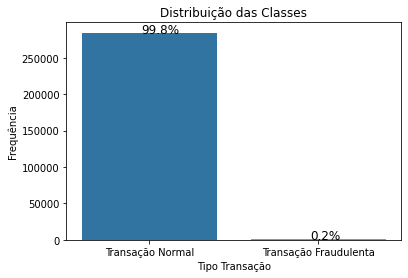

In [7]:
# Distribuição das classes

fig, ax = plt.subplots()
sns.countplot('Class', data=df, ax=ax)
ax.set_title('Distribuição das Classes')
plt.plot()

plt.xlabel("Tipo Transação")
plt.ylabel("Frequência")

ax.set_xticklabels(('Transação Normal', 'Transação Fraudulenta')) 

without_hue(ax, df.Class)


Observe que a frequência das fraudes é tão pequena que é difícil de ser representada na visualização acima, isso acontece porque apenas 0,2% das transações foram fraudulentas o que dificulta ainda mais sua detecção.

Além disso, percebemos que o dataset claramente é desbalanceado. 

Podemos tratar esse problema utilizando técnicas de *Sampling*, como veremos mais adiante

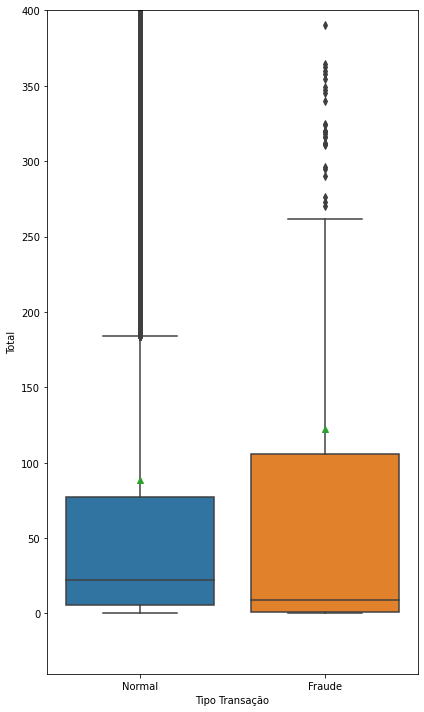

In [8]:
#Boxplots da variável Amount por classe

fig, ax = plt.subplots(figsize=(6,10), sharex=True)

sns.boxplot(df.Class, df.Amount, showmeans=True, ax=ax)
plt.ylim((-40, 400))
plt.xticks([0, 1], ['Normal', 'Fraude'])

plt.xlabel("Tipo Transação")

plt.ylabel("Total")


plt.tight_layout()

Na visualização da variável *amount* (valor das transações) a distribuição dos valores para transações fraudulentas é mais dispersa do que em relação as transações normais, ou não fraudulentas.

Uma homogeneidade maior nos dados pode ocultar relações que estão ocultas a nós mas detectáveis através de algoritmos de machine learning

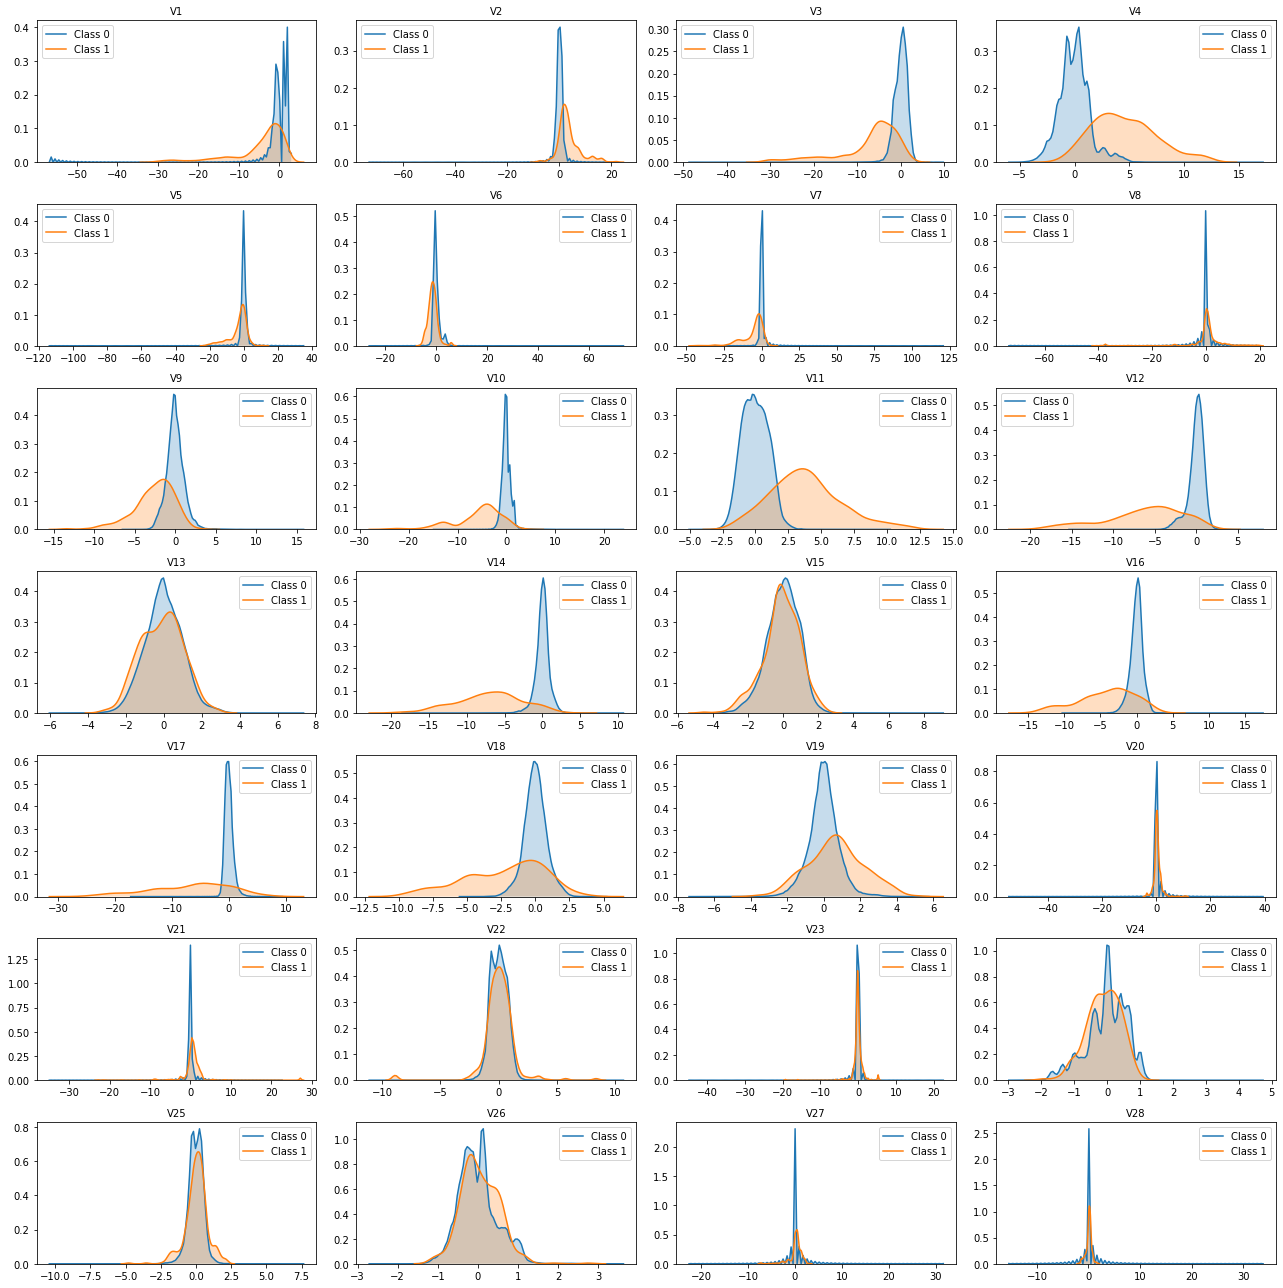

In [9]:
#Analisando a distribuição das variáveis comparando as classes

column_names = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
    sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()

Esse gráfico de densidade ajuda a detectar irregularidades na distribuição dos dados.

Observe como para as variáveis V3, V4, V10, V11, V12 e V16, a distribuição das fraudes difere bastante da distribuição das transações normais. Essas discrepâncias podem trazer mais informações sobre a forma de identificarmos preventivamente o evento fraude quando ele ocorrer.



## Data Engeneering dos dados

Para a execução do modelo de machine learning precisamos:

* Padronizar as features *Time* e *Amount*, que estão em diferentes escalas.

* Dividir entre dados de treino e teste

* Balancear os dados devido ao desbalanceamento natural da classe *fraude* e assim evitar o overfitting.


### Padronizando as colunas *Amount* e *Time*

Sabemos que as componentes principais são elaboradas a partir da matriz de variâncias e covariâncias e por isso são sensíveis a escala das variáveis, assumimos então que as *features* já estão padronizadas.

Porém as variáves referentes ao tempo da transação e o valor que foi transacionado não estão padronizados e precisamos corrigir isso.

In [10]:
#Criando uma cópia do banco
df_clean = df.copy()

#Padronizando
std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))

df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

# ver as primeiras entradas
df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,0.09,-0.55,-0.62,-0.99,-0.31,1.47,-0.47,0.21,0.03,0.40,0.25,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,0,0.24,-2.00
1,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,-0.17,1.61,1.07,0.49,-0.14,0.64,0.46,-0.11,-0.18,-0.15,-0.07,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,0,-0.34,-2.00
2,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,0.21,0.62,0.07,0.72,-0.17,2.35,-2.89,1.11,-0.12,-2.26,0.52,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,0,1.16,-2.00
3,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,-0.05,-0.23,0.18,0.51,-0.29,-0.63,-1.06,-0.68,1.97,-1.23,-0.21,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,0,0.14,-2.00
4,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,0.75,-0.82,0.54,1.35,-1.12,0.18,-0.45,-0.24,-0.04,0.80,0.41,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,0,-0.07,-2.00


### Dividindo dataset de treino e teste


In [11]:
# separar variáveis entre X e y
X = df_clean.drop('Class', axis=1)
y = df['Class']

# Stratify=True garante que os conjuntos de treino e teste tenham proporcianalmente a mesma quantidade de classes  
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

### Balanceamento dos dados

Nessa etapa vamor utilizar da técnica de *under-sampling* para eliminar aleatoriamente entradas da classe majoritária (Transações Normais) de formas a termos mesmo número de ocorrências entre elas.

É sempre bom destacar as vantagens e limitações de uma técnica, e no caso do *under-sampling* o descarte das informações da classe majoritária (Transações Normais) pode, eventualmente, prejudicar as predições dessa mesma classe.

1    369
0    369
dtype: int64


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


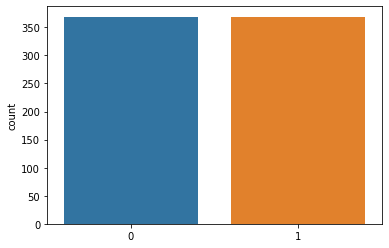

In [12]:
# Técnica under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

# Balanceamento das classes
print(pd.Series(y_rus).value_counts())

# Nova distribuição de classes
sns.countplot(y_rus);

## Modelo de Machine Learning

Vamos utilizar a regressão Logística para construir um classificador .


In [13]:
# Treinamento do modelo de regressão logística
np.random.seed(2)
model = LogisticRegression()
model.fit(X_rus, y_rus)

# Valores dass previsões sobre os dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

### Avaliando o desempenho do modelo

O modelo já foi treinado e as previsões já foram feitas, a próxima etapa então é avaliarmos o desempenho do modelo.

Em problemas que envolvam dados desbalanceados, a acurácia não é a medida mais adequada para avaliar o modelo uma vez que o modelo pode se tornar muito bom em avaliar a classe majoritária e ser ruim para avaliar a classe minoritária 

Por isso, utilizamos outras duas métricas muito sensíveis as previsões feitas: Precisão (que na prática funciona como uma acurácia da classe majoritária) e o Recall

Acurácia: 0.9672

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9673    0.9833     71079
           1     0.0467    0.9268    0.0889       123

    accuracy                         0.9672     71202
   macro avg     0.5233    0.9470    0.5361     71202
weighted avg     0.9982    0.9672    0.9818     71202



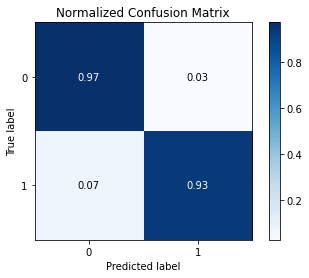

In [14]:
# A matrix de confusão ajuda a dar a dimensão das previsões corretas e incorretas
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# Acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

# O relatório de classificação traz informações sobre a precisão, o recall e o F1-Score
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

A matriz de confusão traz mais clareza sobre as limitações da acurácia, perceba como o modelo prediz melhor as transações normais do que as transações fradulentas.

No relatório de classificação, na coluna Precision, observe como o modelo tem uma precisão alta para classificar as transações normais, mas baixa para calcular transações fraudulentas.

Apesar disso, o Recall do nosso modelo é relativamente bom, uma vez que ele foi capaz de detectar 89% das transações fraudulentas, e 11% das mesmas o modelo não foi capaz de detectar como sendo tais.

Na matriz de confusão, a primeira linha mostra os valores da precisão e a segunda linha os valores do Recall para cada categoria.


# *Conclusão*

A detecção de fraudes não é um processo simples, são necessárias muitas etapas de tratamento dos dados, normalização e balanceamento para finalmente chegarmos a um modelo bem ajustado. 

Além disso, vale a pena testar o desempenho de outros algoritmos de classificação para entender se algum se ajusta melhor do que o de regressão logística.